Walkthrough code of building a multi-layer perceptron from scratch.
- Covers backpropagation, gradient descent, activation funciton learning rate, and loss function.
- Code built from Andrej Kaparthy's youtube tutorial: https://www.youtube.com/watch?v=VMj-3S1tku0&t=5192s

In [62]:
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
%matplotlib inline

In [67]:
class Value:
  """
  Value class defines the object used to calculate gradients for variables/values
  in a function. It looks at the derivative of each variable with respect to
  the output.

  _backward() loops through all nodes and executes the backprogation function
  stored in self._backward variable for each node.

  Implements +, -, /, *, and pow() for integers and floats only.

  """
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data)={self.data}"
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other + self
    return self + other

  def __rsub__(self, other): # other - self
    return other + (-self)

  def __rmul__(self, other): # other * self
    return self * other

  def __rtruediv__ (self, other): #other/self
    return other * self**-1

  def __truediv__(self, other): # self/other
    return self * other**-1

  def __neg__(self):
    return self*-1

  def __sub__(self,other):
    return self + (-other)

  def __pow__(self, other):
    assert isinstance(other,(int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other*self.data**(other-1)) * out.grad# n *x**(n-1)
    out._backward = _backward
    return out
  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2)*out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [68]:
a = Value(2.0)
b = Value(4.0)
a/b

Value(data)=0.5

In [69]:
a/b

Value(data)=0.5

In [49]:
from graphviz import Digraph

def trace(root):
  #builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{%s | data%.4f | grad %.4f}"%(n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node fo n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

**Example of a single neuron and its tanh activation function.**

In [50]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# cell body without activation function
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [51]:
# o = tanh(n)
# do / dn : how does n influence o
  # 1-tanh(n)**2 == (1-o**2) * d/do

In [52]:
# calculate gradients for each variable
o.backward()

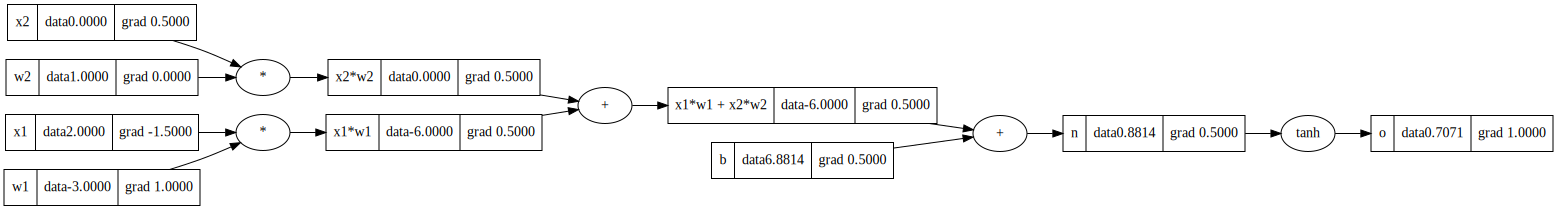

In [53]:
draw_dot(o)

**Same as above, except tanh is defined using exponentials**

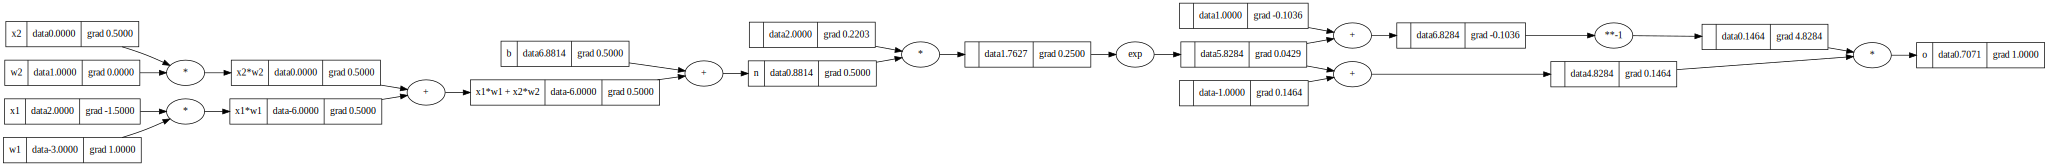

In [57]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# cell body without activation function
n = x1w1x2w2 + b; n.label = 'n'
# Redefine tanh()
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

**Demonstrates use of pytorch to calculate gradients**

In [59]:
import torch

In [60]:
x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


**Define a multilayer perceptron**
Consists of layers made up of neurons

In [103]:
class Neuron:
  def __init__(self, nin):
    # use list comprehension to generate random weights between -1 and 1 for all
    # for 'nin' number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    # generate bias term to control "trigger happiness" of neural network
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # act = w*x + b
    # which is dot product of w and x plus b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # sums on top of base b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    """
    Create layer: list of neurons with 'nout' neurons and nin inputs
    """
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    """
    params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params
    """
    # equivalent to above
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    """
    Takes in # of inputs 'nin' and list denotating # of neurons per layer
    """
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

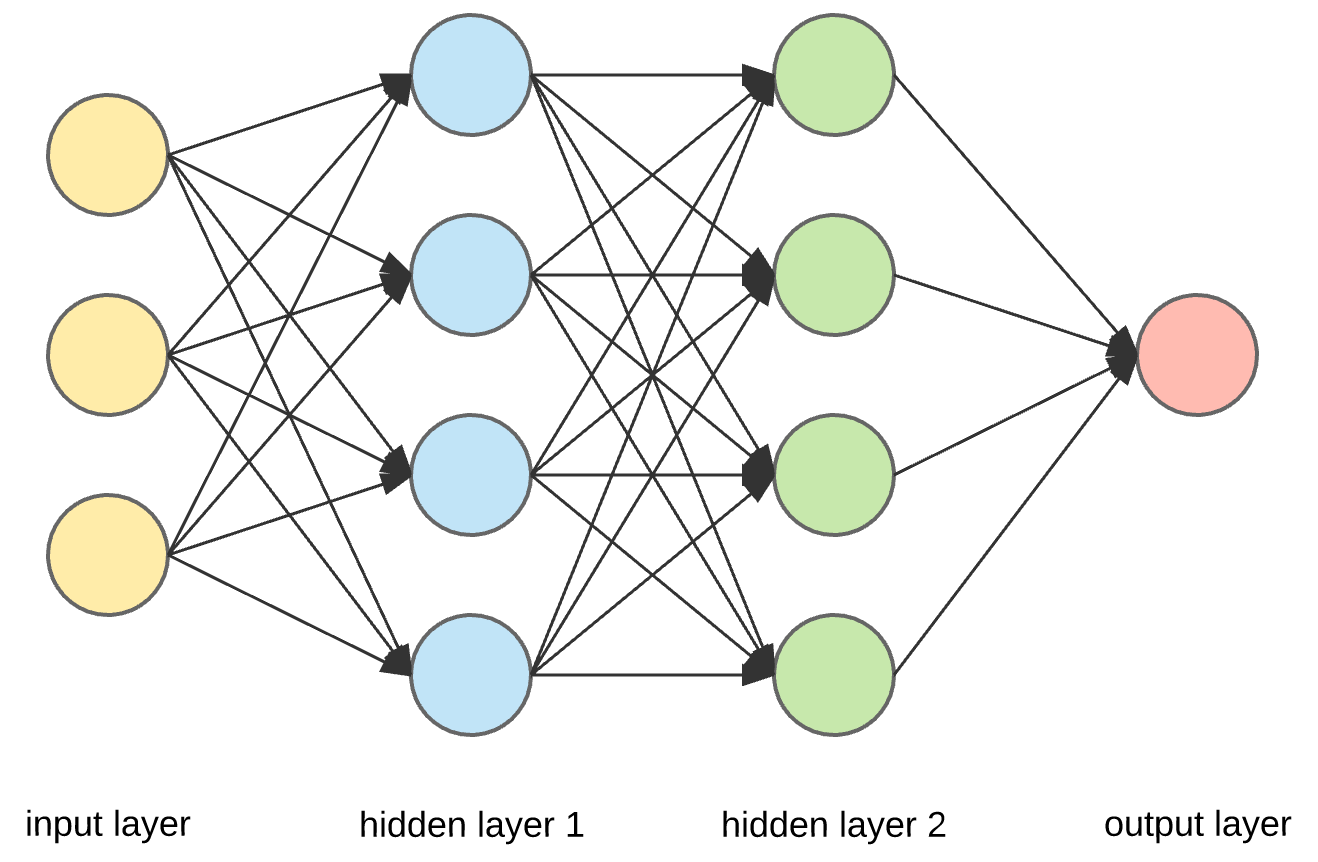

In [171]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data)=-0.45047305054043957

Input layer is composed of x0,x1,x2
Each neuron in Hidden layer is sum of xi*wi+b.

In [173]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [174]:
for k in range(20):
  # forward pass

  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
  # backward pass

  # SUPER IMPORTANT: MUST RESET GRADS TO ZERO SO THE LOSS DERIVATIVES
  # ACCURATELY ACCUMULATE, OTHERWISE THE GRAD REMAINS FROM PREVIOUS
  # ITERATION.
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05*p.grad# tiny update to gradient descent scheme
  print(k, loss.data)

0 6.543244957670955
1 5.1461546342609665
2 3.84191554768943
3 3.689565793266614
4 3.4529865462150795
5 2.8846853641936034
6 1.5276977042773072
7 0.65567560405944
8 0.4171997020933479
9 0.3115992311946082
10 0.2499718427372956
11 0.20862859981234472
12 0.17884453170706938
13 0.15632874006372954
14 0.13869954634819961
15 0.1245208708969048
16 0.11287218098225679
17 0.10313486358349012
18 0.09487723092957956
19 0.08778860312071424


In [175]:
ypred

[Value(data)=0.8608343723363799,
 Value(data)=-0.9518787080848967,
 Value(data)=-0.7859720303517554,
 Value(data)=0.8575292989054366]